In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [76]:
df = pd.read_csv('data/fifa_players_preprocessed.csv')

In [77]:
n_features = [
    'overall', 'height_cm', 'weight_kg', 'weak_foot', 'skill_moves',
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    'potential', 'height_weight_ratio', 'primary_position_enc'
]

In [78]:
c_features = [col for col in df.columns if
              col.startswith("work_rate_") or col.startswith("preferred_foot_") or col.startswith("age_group_")]

features = n_features + c_features
X = df[features]
y_clf = df["high_value"]
scaler = StandardScaler()
X[n_features] = scaler.fit_transform(X[n_features])

C:\Users\user\AppData\Local\Temp\ipykernel_29132\4017860778.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[n_features] = scaler.fit_transform(X[n_features])


In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

In [81]:
param_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "criterion": ["gini", "entropy"]
}

In [82]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.9818372336709745

In [83]:
grid_dt = GridSearchCV(dt, param_grid, cv=5, return_train_score=False)
grid_dt.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


__Logistic Regression was 90% which means for Decision Tree using default hyperparameters increased value up to 1,4% and with best parameters up to 2,2%__

__It was before I added simple yet important feature which is 'Overall' column. This means that this additional column made our model understand the rule of applying prices to our Players which got our Logistic Regression up to 96% and Decision tree 98.1% with default hyperparameters and 98.3% with best parameters__

In [84]:
grid_dt.best_score_

np.float64(0.9835807860262008)

In [85]:
grid_dt.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [86]:
dt_best = grid_dt.best_estimator_
dt_best

,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [87]:
y_pred = dt_best.predict(X_test)

results_df = pd.DataFrame({
    "actual": y_test.values,
    "predicted": y_pred
})

results_df.head(10)

,actual,predicted
0,1,1
1,1,1
2,0,0
3,0,0
4,1,1
5,0,0
6,0,0
7,0,0
8,1,1
9,1,1


In [88]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nDecision Tree Evaluation")
print("-"*40)
print("Accuracy :", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall   :", round(rec, 3))
print("F1-score :", round(f1, 3))


Decision Tree Evaluation
----------------------------------------
Accuracy : 0.983
Precision: 0.984
Recall   : 0.975
F1-score : 0.979


In [89]:
y_train_pred = dt_best.predict(X_train)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)

print("\nOverfitting Check")
print("-"*40)
print("Train F1:", round(train_f1, 3))
print("Test  F1:", round(test_f1, 3))


Overfitting Check
----------------------------------------
Train F1: 0.998
Test  F1: 0.979


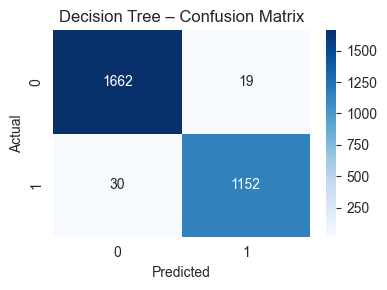

In [90]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree – Confusion Matrix")
plt.tight_layout()
plt.show()


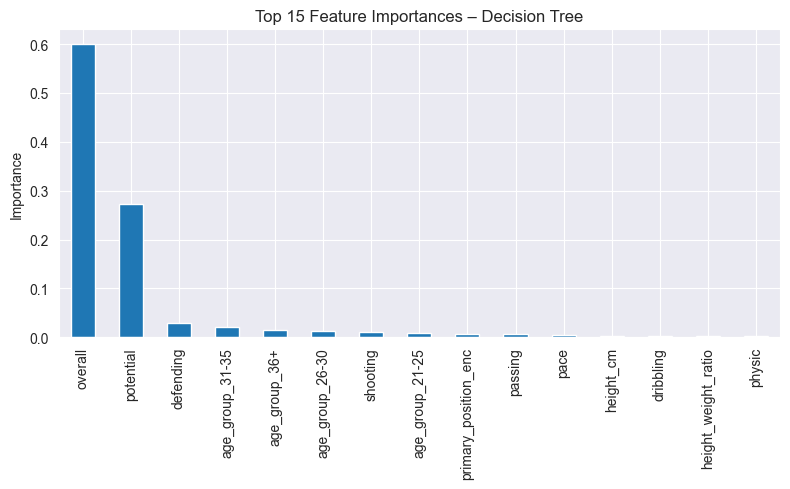

overall                 0.599866
potential               0.272010
defending               0.029163
age_group_31-35         0.020238
age_group_36+           0.014262
age_group_26-30         0.013524
shooting                0.010133
age_group_21-25         0.008038
primary_position_enc    0.007156
passing                 0.005915
pace                    0.004717
height_cm               0.003152
dribbling               0.002692
height_weight_ratio     0.002682
physic                  0.001761
dtype: float64

In [91]:
dt_importances = pd.Series(
    dt_best.feature_importances_,
    index=features
).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
dt_importances.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances – Decision Tree")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

dt_importances.head(15)


===========================================================================

In [92]:
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"]
}


In [93]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9849807893817674

In [95]:
grid_rf = GridSearchCV(rf, rf_param_grid, cv=3, return_train_score=False, n_jobs=-1)

grid_rf.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [96]:
grid_rf.best_score_

np.float64(0.9820962603029919)

In [97]:
grid_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [98]:
rf_best = grid_rf.best_estimator_
rf_best

,n_estimators,200
,criterion,'entropy'
,max_depth,20
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [99]:
y_pred = rf_best.predict(X_test)

results_df = pd.DataFrame({
    "actual": y_test.values,
    "predicted": y_pred
})

results_df.head(10)

,actual,predicted
0,1,1
1,1,1
2,0,0
3,0,0
4,1,1
5,0,0
6,0,0
7,0,0
8,1,1
9,1,1


In [101]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nRandom Forest Evaluation")
print("-"*40)
print("Accuracy :", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall   :", round(rec, 3))
print("F1-score :", round(f1, 3))


Random Forest Evaluation
----------------------------------------
Accuracy : 0.983
Precision: 0.978
Recall   : 0.981
F1-score : 0.98


In [102]:
y_train_pred = rf_best.predict(X_train)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)

print("\nOverfitting Check")
print("-"*40)
print("Train F1:", round(train_f1, 3))
print("Test  F1:", round(test_f1, 3))


Overfitting Check
----------------------------------------
Train F1: 0.999
Test  F1: 0.98


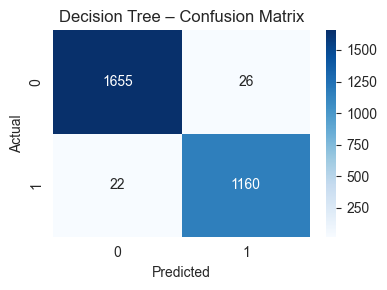

In [103]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree – Confusion Matrix")
plt.tight_layout()
plt.show()

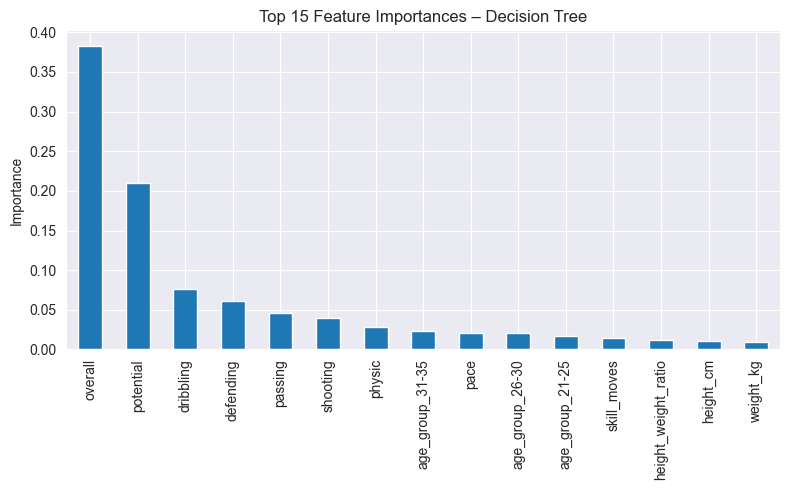

overall                0.383280
potential              0.210123
dribbling              0.076795
defending              0.060462
passing                0.046232
shooting               0.039868
physic                 0.028285
age_group_31-35        0.023753
pace                   0.021093
age_group_26-30        0.020718
age_group_21-25        0.017033
skill_moves            0.014373
height_weight_ratio    0.011723
height_cm              0.010305
weight_kg              0.009410
dtype: float64

In [104]:
dt_importances = pd.Series(
    rf_best.feature_importances_,
    index=features
).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
dt_importances.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances – Decision Tree")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

dt_importances.head(15)

===========================================================================

In [107]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

In [108]:
svm = SVC(random_state=42)

svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.9678658749563395

In [109]:
grid_svm = GridSearchCV(svm, param_grid, cv=3, return_train_score=False, n_jobs=-1)
grid_svm.fit(X_train, y_train)

,estimator,SVC(random_state=42)
,param_grid,"{'C': [0.1, 1, ...], 'gamma': [0.001, 0.01, ...], 'kernel': ['rbf', 'linear']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,100


In [110]:
grid_svm.best_score_

np.float64(0.9747597181464291)

In [111]:
grid_svm.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [112]:
svm_best = grid_svm.best_estimator_
svm_best

,C,100
,kernel,'rbf'
,degree,3
,gamma,0.01
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [114]:
y_pred = svm_best.predict(X_test)

results_df = pd.DataFrame({
    "actual": y_test.values,
    "predicted": y_pred
})

results_df.head(10)

,actual,predicted
0,1,1
1,1,1
2,0,0
3,0,0
4,1,1
5,0,0
6,0,0
7,0,0
8,1,1
9,1,1


In [115]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nSupport Vectore Machine Evaluation")
print("-"*40)
print("Accuracy :", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall   :", round(rec, 3))
print("F1-score :", round(f1, 3))


Support Vectore Machine Evaluation
----------------------------------------
Accuracy : 0.973
Precision: 0.969
Recall   : 0.965
F1-score : 0.967


In [116]:
y_train_pred = svm_best.predict(X_train)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)

print("\nOverfitting Check")
print("-"*40)
print("Train F1:", round(train_f1, 3))
print("Test  F1:", round(test_f1, 3))


Overfitting Check
----------------------------------------
Train F1: 0.983
Test  F1: 0.967


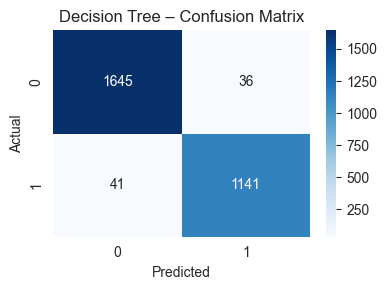

In [118]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree – Confusion Matrix")
plt.tight_layout()
plt.show()